### Import packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import dill
import yaml
import numpy as np
import pandas as pd
import ast

import seaborn as sns
sns.set(style='ticks')

### Import submodular-optimization packages

In [2]:
sys.path.insert(0, "/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/")

### Visualizations directory

In [3]:
VIZ_DIR = os.path.abspath("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/viz/")

### Plotting utilities

In [4]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})

In [5]:
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()

In [6]:
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=600, format='pdf', bbox_inches='tight')

### Plots

In [7]:
df = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_02.csv",
                header=0,
                index_col=False)

df.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

#### Details
Original marginal gain: $$g(e|S) = f(e|S) - w(e)$$
Scaled marginal gain: $$\tilde{g}(e|S) = f(e|S) - 2w(e)$$
Distorted marginal gain: $$\tilde{g}(e|S) = (1-\frac{\gamma}{k})^{k-(i+1)}f(e|S) - w(e)$$ 
Single threshold marginal gain: $$\tilde{g}(e|S) = f(e|S) - (\frac{1}{2}(3+\sqrt{5}))w(e)$$

#### Algorithms:

1. Cost Scaled Greedy: The algorithm performs iterations i = 0,...,k-1. In each iteration the algorithm selects the element that maximizes the scaled marginal gain. It adds the element to the solution if the original marginal gain of the element is >= 0. The algorithm returns a solution S: f(S) - w(S) >= (1/2)f(OPT) - w(OPT). The running time is O($nk$). 


2. Cost Scaled Exact Lazy Greedy: The algorithm first initializes a max heap with all the elements. The key of each element is its scaled marginal gain and the value is the element id. If the scaled marginal gain of an element is < 0 the algorithm discards the element and never inserts it in the heap. Then, for 0,...,k-1 iterations the algorithm does the following: (i) pops the top element from the heap and computes its new scaled marginal gain, (ii) It checks the old scaled marginal gain of the next element in the heap, (iii) if the popped element's new scaled marginal gain is >= the next elements's old gain we return the popped element, otherwise if its new scaled marginal gain is >= 0 we reinsert the element to the heap and repeat step iii, otherwise we discard it and repeat step iii, (iv) if the returned element's original marginal gain is >= 0 we add it to the solution. The algorithm returns a solution S: f(S) - w(S) >= (1/2)f(OPT) - w(OPT). The running time is O($nk$). 


3. Scaled Single Threshold Greedy: The algorithm performs i = 0,...,n-1 iterations (one for each arriving element). For each element arriving the algorithm computes its corresponding single threshold marginal gain wrt the empty set. If the element's gain is the largest so far it updates the largest gain denoted as m. The algorithm then creates the set of thresholds $O_i = \{v=(1+ε)^i: m <= (1+ε)^i <= 2*k*m\}$, where m is the largest gain observed so far and k is the cardinality constraint. The algorithm maintains a set S containing the solutions that correspond to each threshold v in the set of thresholds $O_i$. In iteration i if a threshold v has not been observed before it creates a set S_v that corresponds to it. If a threshold v exists in S but not in $O_i$ it deletes this solution. The algorithm adds the current element $e_i$ to all sets that meet the conditions in line 9 of Algorithm 3 found [here](http://www.cs.cornell.edu/~ashwin85/docs/frp0328-badanidiyuru.pdf). At the end the algorithm returns the set S that maximizes the original objective function. We set $ε=0.1$. The algorithm returns a solution S: f(S) - w(S) >= (1/2 - ε)(3-$\sqrt{5}$)f(OPT) - w(OPT). The running time is O($n\log{k}/ε$). The algorithmic implementation is based on Algorithm 3 found [here](http://www.cs.cornell.edu/~ashwin85/docs/frp0328-badanidiyuru.pdf).


4. Distorted Greedy: The algorithm performs i = 0,...,k-1 iterations, where k is the cardinality constraint. In each iteration the algorithm selects the element that maximizes the distorted marginal gain. It adds the element to the solution if the distorted marginal gain of the element is > 0. The algorithm returns a solution S: f(S) - w(S) >= (1-1/e)f(OPT) - w(OPT). The running time is O($nk$). The algorithmic implementation is based on Algorithm 1 found [here](https://arxiv.org/pdf/1904.09354.pdf).


5. Stochastic Distorted Greedy: The algorithm performs i = 0,...,k-1 iterations, where k is the cardinality constraint. In each iteration the algorithm chooses a sample of s=(n/k)log(1/ε) elements uniformly and independently and from this sample it selects the element that maximizes the distorted marginal gain. It adds the element to the solution if the distorted marginal gain of the element is > 0. We set $ε=0.01$. The algorithm returns a solution S: E[f(S) - w(S)] >= (1-1/e-ε)f(OPT) - w(OPT). The running time is O($n\log{1/ε}$). The algorithmic implementation is based on Algorithm 2 found [here](https://arxiv.org/pdf/1904.09354.pdf).

#### Performance comparison

In [8]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='k', y='val', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('k')
    plt.ylabel('Value of objective function')
    plt.title('Performance comparison')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

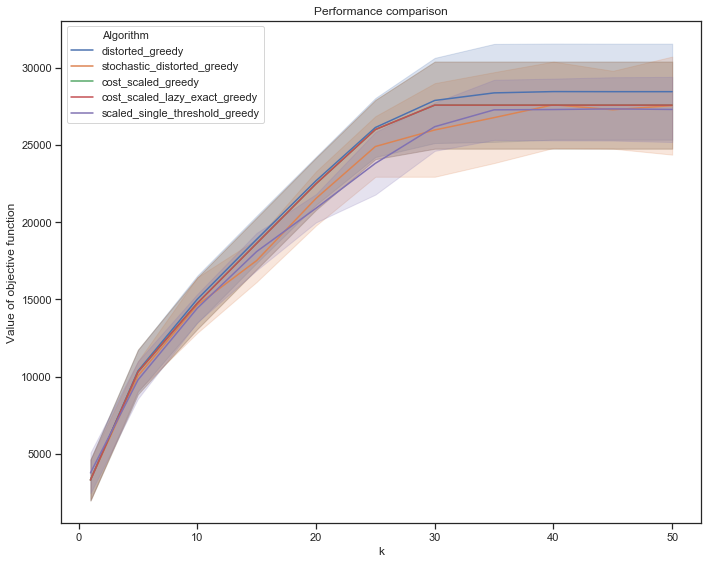

In [9]:
df = df[(df.Algorithm == 'distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy')
        |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_exact_greedy')
        |(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df0 = df[(df['user_sample_ratio'] == 0.4)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)

#### Runtime comparison for individual k

To conduct the runtime experiment for individual k we do the following: (i) for the constant scaled algorithms create the greedy prefix and when the prefix reaches the budget k, return the solution, (ii) for the distorted algorithms run the algorithm for k iterations, (iii) for the streaming algorithm we iterate over every element in the stream and at the end output the best solution of size k

In [10]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='k', y='runtime', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('k')
    plt.ylabel('Time (sec)')
    plt.title('Performance comparison')
    # plt.yscale('log')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

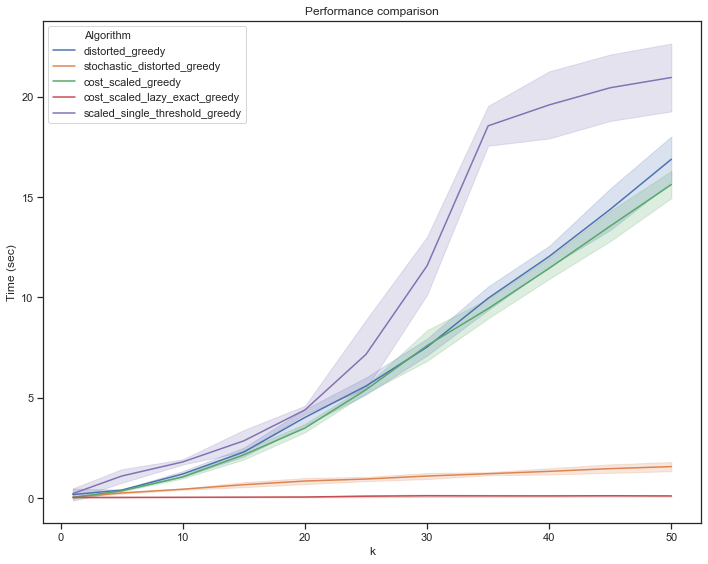

In [11]:
df = df[(df.Algorithm == 'distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy')
        |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_exact_greedy')
        |(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df0 = df[(df['user_sample_ratio'] == 0.4)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)

#### Runtime comparison for cumulative k

To conduct the runtime experiment for cumulative k we do the following: (i) for the constant scaled algorithms iterate for i=1,...,n and create the greedy ordering once. For every k output the ordered prefix of size k. If a prefix of size k does not exist output the entire greedy ordering. (ii) for the distorted algorithms run the algorithm for each of k = 1,...,n. The running time for every k is the summation of the running times for the previous (smaller) k values. (iii) for the streaming algorithm do the same as (ii).

In [12]:
df = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_03.csv",
                header=0,
                index_col=False)

df.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

In [13]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='k', y='runtime', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('k')
    plt.ylabel('Time (sec)')
    plt.title('Performance comparison')
    # plt.yscale('log')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

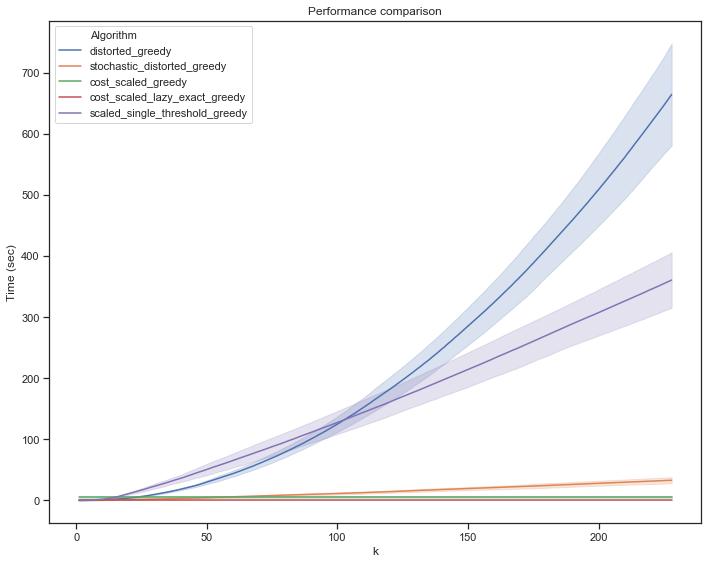

In [14]:
df = df[(df.Algorithm == 'distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy')
        |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_exact_greedy')
        |(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df0 = df[(df['user_sample_ratio'] == 0.05)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)